In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.core.display import display, HTML
import time

In [116]:
zomato_data = pd.read_csv("/content/drive/MyDrive/Innomatics Hackathon/zomato_data.csv")
zomato_data.shape

(51717, 10)

In [117]:
zomato_data.head()

,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity
0,Yes,Yes,4.1/5,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Yes,No,4.1/5,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet,Banashankari
2,Yes,No,3.8/5,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,No,No,3.7/5,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari
4,No,No,3.8/5,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari


In [118]:
import re

def find_res(df):
  north_indian_ct = 0
  for cuisines in df['cuisines']:
    if isinstance(cuisines, str):
      if re.search(r'\bNorth Indian\b', cuisines, re.IGNORECASE):
          north_indian_ct += 1
  return north_indian_ct

north_indian_ct = find_res(zomato_data)
print(f"The number of restaurants that serve North Indian cuisine is: {north_indian_ct}")

The number of restaurants that serve North Indian cuisine is: 21085


In [119]:
cuisine_counts = zomato_data['cuisines'].str.split(', ').explode().value_counts()
print(cuisine_counts)

cuisines
North Indian    21085
Chinese         15547
South Indian     8644
Fast Food        8096
Biryani          6492
                ...  
Sindhi              4
Pan Asian           3
Hot dogs            3
Indian              2
Malwani             2
Name: count, Length: 107, dtype: int64


In [120]:
zomato_data.columns

Index(['online_order', 'book_table', 'rate', 'votes', 'rest_type',
       'dish_liked', 'cuisines', 'approx_costfor_two_people', 'listed_intype',
       'listed_incity'],
      dtype='object')

In [121]:
zomato_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   online_order               51717 non-null  object
 1   book_table                 51717 non-null  object
 2   rate                       43942 non-null  object
 3   votes                      51717 non-null  int64 
 4   rest_type                  51490 non-null  object
 5   dish_liked                 23639 non-null  object
 6   cuisines                   51672 non-null  object
 7   approx_costfor_two_people  51371 non-null  object
 8   listed_intype              51717 non-null  object
 9   listed_incity              51717 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.9+ MB


# Data Cleaning and Preprocessing

### Rate

In [122]:
# Replace '-' values with NaN
zomato_data['rate'] = zomato_data['rate'].replace('-', pd.NA)

# Remove '/5' and retain only the numeric value
zomato_data['rate'] = zomato_data['rate'].str.replace('/5', '', regex=False)

# Convert to float
zomato_data['rate'] = pd.to_numeric(zomato_data['rate'], errors='coerce')

# Fill missing values using the median rating
median_rating = zomato_data['rate'].median()
zomato_data['rate'] = zomato_data['rate'].fillna(median_rating)

zomato_data.head()

,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity
0,Yes,Yes,4.1,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Yes,No,4.1,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet,Banashankari
2,Yes,No,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,No,No,3.7,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari
4,No,No,3.8,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari


### approx_costfor_two_people

In [123]:
# Convert 'approx_costfor_two_people' to numeric by removing non-numeric characters and converting to float
zomato_data['approx_costfor_two_people'] = zomato_data['approx_costfor_two_people'].str.replace(',', '', regex=False).astype(float)

In [124]:
median_cost = zomato_data['approx_costfor_two_people'].median()

# Fill missing values in 'approx_costfor_two_people' with the median cost
zomato_data['approx_costfor_two_people'] = zomato_data['approx_costfor_two_people'].fillna(median_cost)

In [125]:
# Group by 'listed_incity' and calculate the average cost
average_cost_by_city = zomato_data.groupby('listed_incity')['approx_costfor_two_people'].mean().sort_values(ascending=False)

average_cost_by_city

,approx_costfor_two_people
listed_incity,
Church Street,770.361248
Brigade Road,766.676088
MG Road,759.364992
Lavelle Road,751.151950
Residency Road,739.573457
Indiranagar,652.973118
Old Airport Road,605.698246
Whitefield,577.722222
Malleshwaram,574.470803


### Categorical Columns

In [126]:
# Replace NaN values in categorical columns with specified values
zomato_data['dish_liked'] = zomato_data['dish_liked'].fillna('Not Available')
zomato_data['cuisines'] = zomato_data['cuisines'].fillna('Other')
zomato_data['rest_type'] = zomato_data['rest_type'].fillna('Unknown')

### Votes

In [127]:
# Fill missing values in 'votes' with the median
median_votes = zomato_data['votes'].median()
zomato_data['votes'] = zomato_data['votes'].fillna(median_votes)

### Binary Encoding

In [128]:
zomato_data['online_order'] = zomato_data['online_order'].map({'Yes': 1, 'No': 0})
zomato_data['book_table'] = zomato_data['book_table'].map({'Yes': 1, 'No': 0})

In [129]:
zomato_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   online_order               51717 non-null  int64  
 1   book_table                 51717 non-null  int64  
 2   rate                       51717 non-null  float64
 3   votes                      51717 non-null  int64  
 4   rest_type                  51717 non-null  object 
 5   dish_liked                 51717 non-null  object 
 6   cuisines                   51717 non-null  object 
 7   approx_costfor_two_people  51717 non-null  float64
 8   listed_intype              51717 non-null  object 
 9   listed_incity              51717 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 3.9+ MB


In [143]:
#zomato_data.to_csv('/content/drive/MyDrive/Innomatics Hackathon/zomato_data_cleaned.csv', index=False)

In [131]:
df=pd.read_csv('/content/drive/MyDrive/Innomatics Hackathon/zomato_data_cleaned.csv')

In [132]:
high_votes_data = df[df['votes'] > 1000]
highest_rated_restaurant_type = high_votes_data.groupby('rest_type')['rate'].mean()

highest_rating = high_votes_data.groupby('rest_type')['rate'].mean()

highest_rated_restaurant_type, highest_rating

(rest_type
 Bakery                         4.800000
 Bakery, Cafe                   4.353846
 Bar                            4.195181
 Bar, Casual Dining             4.366667
 Bar, Quick Bites               4.000000
 Cafe                           4.216749
 Cafe, Bakery                   4.312500
 Cafe, Casual Dining            4.485185
 Cafe, Dessert Parlor           4.578261
 Casual Dining                  4.218219
 Casual Dining, Bar             4.399754
 Casual Dining, Cafe            4.340171
 Casual Dining, Irani Cafee     4.406667
 Casual Dining, Microbrewery    4.347619
 Casual Dining, Pub             4.259649
 Club                           4.047059
 Delivery                       4.268966
 Dessert Parlor                 4.518367
 Dessert Parlor, Cafe           4.315686
 Fine Dining                    4.284848
 Fine Dining, Lounge            4.400000
 Lounge                         4.185950
 Lounge, Cafe                   3.993750
 Lounge, Casual Dining          4.171429
 Loun

In [133]:
filtered_data = df[(df['approx_costfor_two_people'] >= 200) & (df['approx_costfor_two_people'] <= 1000)]

minimum_cost = filtered_data['approx_costfor_two_people'].min()

minimum_cost

200.0

### What percentage of total online orders is received by restaurants in Banashankari?

In [134]:
df['listed_incity'].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

In [135]:
df['online_order'] = df['online_order'].astype(bool)

# Count total online orders
total_online_orders = df[df['online_order'] == True].shape[0]

# Count online orders from Banashankari
banashankari_online_orders = df[(df['online_order'] == True) &
                               (df['listed_incity'] == 'Banashankari')].shape[0]

# Calculate percentage
percentage = (banashankari_online_orders / total_online_orders) * 100

print(f"Total online orders: {total_online_orders}")
print(f"Online orders from Banashankari: {banashankari_online_orders}")
print(f"Percentage of online orders from Banashankari: {percentage:.2f}%")

Total online orders: 30444
Online orders from Banashankari: 546
Percentage of online orders from Banashankari: 1.79%


### Which locality has the most restaurants with over 500 votes and a rating below 3.0?

In [136]:
temp_df = df[(df['votes'] > 500) & (df['rate'] < 3.0)]

# Count restaurants by locality
locality_counts = temp_df['listed_incity'].value_counts()

if len(locality_counts) > 0:
    top_locality = locality_counts.index[0]
    count = locality_counts.iloc[0]

    print(f"The locality with the most restaurants having over 500 votes and rating below 3.0 is: {top_locality}")
    print(f"Number of such restaurants: {count}")

    print("\nTop localities by number of poorly rated but popular restaurants:")
    print(locality_counts.head(5))


The locality with the most restaurants having over 500 votes and rating below 3.0 is: Brookefield
Number of such restaurants: 8

Top localities by number of poorly rated but popular restaurants:
listed_incity
Brookefield         8
Whitefield          6
Indiranagar         4
Old Airport Road    4
Marathahalli        3
Name: count, dtype: int64


### Which locality in Bangalore should Zomato target for expansion based on restaurant type diversity?

In [137]:
# Count unique restaurant types by locality
rest_type_diversity = df.groupby('listed_incity')['rest_type'].nunique().sort_values(ascending=False)
rest_type_diversity

,rest_type
listed_incity,
BTM,62
Brigade Road,61
Church Street,61
Lavelle Road,59
MG Road,59
Koramangala 4th Block,59
Koramangala 6th Block,59
Koramangala 5th Block,58
Koramangala 7th Block,58


In [138]:
# Get the top 10 localities with the most diverse restaurant types
top_localities = rest_type_diversity.head(10)

print("Top 10 localities by restaurant type diversity:")
print(top_localities)

# For the top locality, show the distribution of restaurant types
top_locality = rest_type_diversity.index[0]
print(f"\nRestaurant types in {top_locality}:")
top_locality_rest_types = df[df['listed_incity'] == top_locality]['rest_type'].value_counts()
print(top_locality_rest_types.head(10))  # Show top 10 restaurant types

# Count total number of unique restaurant types in the dataset
total_unique_rest_types = df['rest_type'].nunique()
print(f"\nTotal unique restaurant types in the dataset: {total_unique_rest_types}")
print(f"Number of unique restaurant types in {top_locality}: {rest_type_diversity.iloc[0]} ({rest_type_diversity.iloc[0]/total_unique_rest_types*100:.2f}% of all types)")

Top 10 localities by restaurant type diversity:
listed_incity
BTM                      62
Brigade Road             61
Church Street            61
Lavelle Road             59
MG Road                  59
Koramangala 4th Block    59
Koramangala 6th Block    59
Koramangala 5th Block    58
Koramangala 7th Block    58
Residency Road           57
Name: rest_type, dtype: int64

Restaurant types in BTM:
rest_type
Quick Bites           1305
Casual Dining          602
Cafe                   261
Delivery               176
Takeaway, Delivery     148
Dessert Parlor         128
Beverage Shop           72
Bakery                  68
Casual Dining, Bar      58
Food Court              47
Name: count, dtype: int64

Total unique restaurant types in the dataset: 94
Number of unique restaurant types in BTM: 62 (65.96% of all types)


In [139]:
if top_locality in df['listed_incity'].values:
    top_rest_types = df[df['listed_incity'] == top_locality]['rest_type'].value_counts().head(5)
    top_cuisines = df[df['listed_incity'] == top_locality]['cuisines'].value_counts().head(5)

    print(f"\nTop 5 restaurant types in {top_locality}:")
    print(top_rest_types)

    print(f"\nTop 5 cuisines in {top_locality}:")
    print(top_cuisines)


Top 5 restaurant types in BTM:
rest_type
Quick Bites           1305
Casual Dining          602
Cafe                   261
Delivery               176
Takeaway, Delivery     148
Name: count, dtype: int64

Top 5 cuisines in BTM:
cuisines
North Indian             195
North Indian, Chinese    175
South Indian              70
Fast Food                 60
Biryani                   53
Name: count, dtype: int64


### What's the average cost difference between buffet and delivery restaurants?

In [140]:
# average cost for buffet restaurants
buffet_restaurants = df[df['listed_intype'] == 'Buffet']
buffet_avg_cost = buffet_restaurants['approx_costfor_two_people'].mean()

# average cost for delivery restaurants
delivery_restaurants = df[df['listed_intype'] == 'Delivery']
delivery_avg_cost = delivery_restaurants['approx_costfor_two_people'].mean()

cost_difference = abs(buffet_avg_cost - delivery_avg_cost)

print(f"\nNumber of buffet restaurants: {len(buffet_restaurants)}")
print(f"Average cost for two at buffet restaurants: Rs.{buffet_avg_cost:.2f}")

print(f"\nNumber of delivery restaurants: {len(delivery_restaurants)}")
print(f"Average cost for two at delivery restaurants: Rs.{delivery_avg_cost:.2f}")

print(f"\nAbsolute difference in average cost: Rs.{cost_difference:.2f}")


Number of buffet restaurants: 882
Average cost for two at buffet restaurants: Rs.1295.35

Number of delivery restaurants: 25942
Average cost for two at delivery restaurants: Rs.464.10

Absolute difference in average cost: Rs.831.25


### What is the maximum number of votes received by any restaurant with online ordering?

In [141]:
# Filter restaurants with online ordering
filtered_res = df[df['online_order'] == 1]

# Find the restaurant with the maximum votes
max_votes_restaurant = filtered_res.loc[filtered_res['votes'].idxmax()]

print(f"Maximum votes received by any restaurant with online ordering: {max_votes_restaurant['votes']}")
print("\nDetails of the restaurant with maximum votes:")
print(f"Restaurant type: {max_votes_restaurant['rest_type']}")
print(f"Cuisines: {max_votes_restaurant['cuisines']}")
print(f"Rating: {max_votes_restaurant['rate']}")
print(f"Cost for two: ₹{max_votes_restaurant['approx_costfor_two_people']}")
print(f"Listed in: {max_votes_restaurant['listed_intype']}")
print(f"Location: {max_votes_restaurant['listed_incity']}")


Maximum votes received by any restaurant with online ordering: 16832

Details of the restaurant with maximum votes:
Restaurant type: Microbrewery
Cuisines: Continental, North Indian, Italian, South Indian, Finger Food
Rating: 4.9
Cost for two: ₹1600.0
Listed in: Delivery
Location: Sarjapur Road


### What is the average rating of restaurants that serve both North Indian and Chinese cuisines?

In [146]:
pattern = r'(?=.*North\s*Indian)(?=.*Chinese)|(?=.*Chinese)(?=.*North\s*Indian)'

filtered_res_nc = df[df['cuisines'].str.contains(pattern, regex=True, na=False)]
avg_rating = filtered_res_nc['rate'].mean()

count = len(filtered_res_nc)

print(f"Number of restaurants serving both North Indian and Chinese cuisines: {count}")
print(f"Average rating of restaurants serving both North Indian and Chinese cuisines: {avg_rating:.2f}")

Number of restaurants serving both North Indian and Chinese cuisines: 11394
Average rating of restaurants serving both North Indian and Chinese cuisines: 3.59


### In which area should Zomato invest by considering high rating (rate > 4.2), high number of votes (> 500) and including online orders?

In [150]:
# high-rated restaurants with online ordering and high engagement
high_potential = df[(df['rate'] > 4.2) &
                    (df['votes'] > 500) &
                    (df['online_order'] == 1)]

# Group by area count of high-potential restaurants
area_potential = high_potential.groupby('listed_incity').size().sort_values(ascending=False)

# top 15 areas with the most high-potential restaurants
print("Top 15 areas with high-rated, popular restaurants offering online ordering:")
print(area_potential.head(15))


Top 15 areas with high-rated, popular restaurants offering online ordering:
listed_incity
Koramangala 7th Block    97
MG Road                  97
Church Street            95
Koramangala 4th Block    95
Brigade Road             94
Koramangala 5th Block    92
BTM                      91
Koramangala 6th Block    90
Lavelle Road             82
Residency Road           81
Indiranagar              80
Old Airport Road         64
Frazer Town              56
Jayanagar                56
Bellandur                55
dtype: int64


In [152]:
# average cost and rating for these top areas
top_areas = area_potential.head(10).index
top_areas_analysis = high_potential[high_potential['listed_incity'].isin(top_areas)].groupby('listed_incity').agg({
    'rate': 'mean',
    'votes': 'mean',
    'approx_costfor_two_people': 'mean'
}).sort_values('rate', ascending=False)

print("\nAnalysis of top 10 areas:")
print(top_areas_analysis)


Analysis of top 10 areas:
                           rate        votes  approx_costfor_two_people
listed_incity                                                          
BTM                    4.446154  2396.021978                 993.956044
Koramangala 6th Block  4.436667  2536.855556                1013.333333
Koramangala 5th Block  4.435870  2522.869565                1026.630435
Koramangala 7th Block  4.434021  2427.628866                1001.030928
Koramangala 4th Block  4.427368  2255.936842                 990.526316
Residency Road         4.403704  1836.814815                1333.333333
MG Road                4.402062  1872.000000                1268.041237
Lavelle Road           4.401220  1767.621951                1290.243902
Church Street          4.395789  1909.105263                1229.473684
Brigade Road           4.395745  1940.840426                1268.617021


In [148]:
# restaurant types in the top area
top_area = area_potential.index[0]
top_area_rest_types = high_potential[high_potential['listed_incity'] == top_area]['rest_type'].value_counts().head(5)
print(f"\nTop 5 restaurant types in {top_area}:")
print(top_area_rest_types)


Top 5 restaurant types in Koramangala 7th Block:
rest_type
Casual Dining          29
Casual Dining, Bar     11
Cafe                   11
Casual Dining, Cafe     9
Quick Bites             6
Name: count, dtype: int64


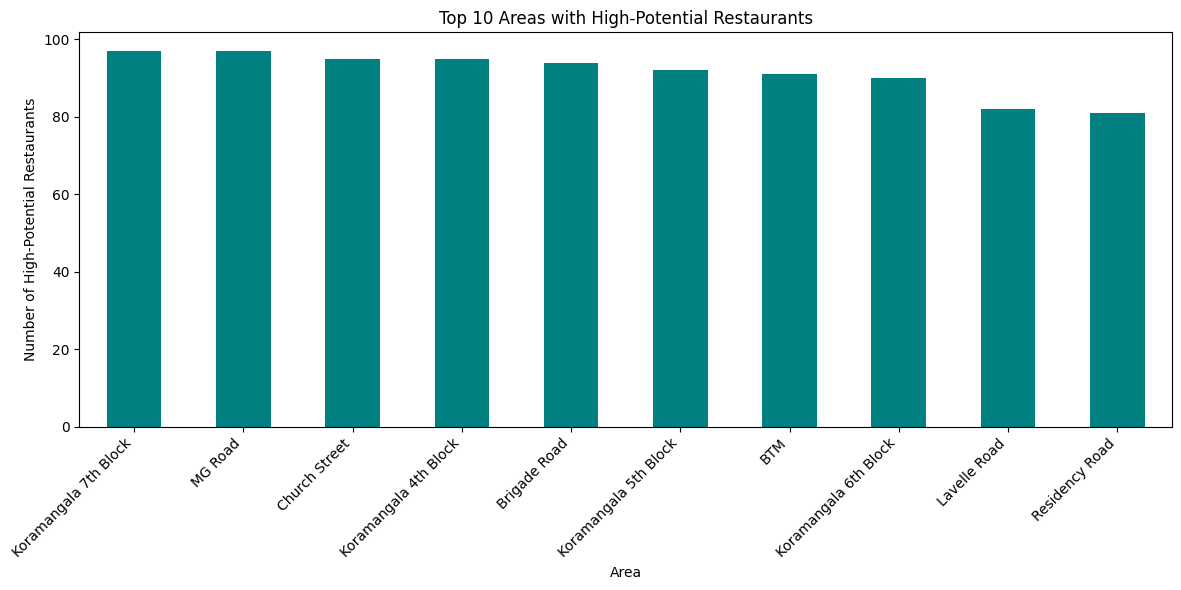

In [153]:
# visualization of the top 10 areas
plt.figure(figsize=(12, 6))
area_potential.head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Areas with High-Potential Restaurants')
plt.xlabel('Area')
plt.ylabel('Number of High-Potential Restaurants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Geospatial Visualization Task

# Restaurant Density Map

In [154]:
data1_cleaned=df.copy()
data2=pd.read_csv('/content/drive/MyDrive/Innomatics Hackathon/Geographical Coordinates.csv')
merged_df = pd.merge(data1_cleaned, data2, on='listed_incity', how='left')

In [156]:
merged_df.head()

,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity,Latitude,Longitude
0,True,1,4.1,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari,12.939333,77.553982
1,True,0,4.1,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,Banashankari,12.939333,77.553982
2,True,0,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,12.939333,77.553982
3,False,0,3.7,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,Banashankari,12.939333,77.553982
4,False,0,3.8,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,Banashankari,12.939333,77.553982


In [158]:
#merged_df.to_csv('/content/drive/MyDrive/Innomatics Hackathon/merged_df.csv', index=False)

In [163]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [164]:
# Check for missing values in coordinates
missing_coords = merged_df[merged_df['Latitude'].isna() | merged_df['Longitude'].isna()]
print(f"\nNumber of restaurants with missing coordinates: {len(missing_coords)}")


Number of restaurants with missing coordinates: 0


In [162]:
# Remove rows with missing coordinates
merged_df = merged_df.dropna(subset=['Latitude', 'Longitude'])
print(f"Number of restaurants with valid coordinates: {len(merged_df)}")

Number of restaurants with valid coordinates: 46137


In [166]:
# base map centered around Bangalore
bangalore_coords = [12.9716, 77.5946]  # Approximate center of Bangalore
map_bangalore = folium.Map(location=bangalore_coords, zoom_start=12)

# map title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Restaurant Density Map of Bangalore</b></h3>
             '''
map_bangalore.get_root().html.add_child(folium.Element(title_html))

# marker cluster
marker_cluster = MarkerCluster().add_to(map_bangalore)

# markers for each restaurant
for idx, row in merged_df.iterrows():
    # Only process every 10th restaurant to avoid overloading the map
    if idx % 10 == 0:
        # popup content
        popup_content = f"""
        <b>Area:</b> {row['listed_incity']}<br>
        <b>Type:</b> {row['rest_type']}<br>
        <b>Cuisines:</b> {row['cuisines']}<br>
        <b>Rating:</b> {row['rate']}<br>
        <b>Cost for Two:</b> ₹{row['approx_costfor_two_people']}<br>
        """

        # assign marker color based on rating
        if pd.isna(row['rate']):
            color = 'gray'
        elif row['rate'] >= 4.0:
            color = 'green'
        elif row['rate'] >= 3.0:
            color = 'blue'
        else:
            color = 'red'

        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_content, max_width=300),
            icon=folium.Icon(color=color, icon='cutlery', prefix='fa'),
        ).add_to(marker_cluster)


heat_data = [[row['Latitude'], row['Longitude']] for _, row in merged_df.iterrows()]
HeatMap(heat_data, radius=15).add_to(map_bangalore)
folium.LayerControl().add_to(map_bangalore)

# legend
legend_html = '''
<div style="position: fixed;
     bottom: 50px; right: 50px; width: 180px; height: 120px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;
     ">
     <b>Restaurant Ratings</b><br>
     <i class="fa fa-circle" style="color:green"></i> 4.0+ &nbsp;&nbsp;High<br>
     <i class="fa fa-circle" style="color:blue"></i> 3.0-3.9 Medium<br>
     <i class="fa fa-circle" style="color:red"></i> Below 3.0 Low<br>
     <hr>
     <b>Density:</b> Heatmap Layer
</div>
'''
map_bangalore.get_root().html.add_child(folium.Element(legend_html))


In [170]:
map_bangalore.save('/content/drive/MyDrive/Innomatics Hackathon/bangalore_restaurant_density_map.html')

In [169]:
map_bangalore.show_in_browser()

Your map should have been opened in your browser automatically.
Press ctrl+c to return.


# Cuisine-Specific Map (Italian Restaurants)

In [175]:
# Filter Italian cuisine
italian_df = merged_df[merged_df['cuisines'].str.contains('Italian', case=False, na=False)]
print(f"Total number of Italian restaurants: {len(italian_df)}")

Total number of Italian restaurants: 3046


In [176]:
italian_df.head()

,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity,Latitude,Longitude
2,True,0,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,12.939333,77.553982
7,True,1,4.6,2556,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",600.0,Cafes,Banashankari,12.939333,77.553982
8,True,0,4.0,324,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","Cafe, Italian, Continental",700.0,Cafes,Banashankari,12.939333,77.553982
9,True,0,4.2,504,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","Cafe, Mexican, Italian, Momos, Beverages",550.0,Cafes,Banashankari,12.939333,77.553982
11,True,1,4.2,150,Cafe,"Mocktails, Peri Fries, Lasagne, Pizza, Chicken...","Cafe, Italian, Continental",600.0,Cafes,Banashankari,12.939333,77.553982


In [177]:
# map centered at the mean coordinates
center_lat = italian_df['Latitude'].mean()
center_lon = italian_df['Longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# marker cluster
marker_cluster = MarkerCluster().add_to(m)

# markers for each restaurant
for idx, row in italian_df.iterrows():

    popup_content = f"""
    <b>{row.get('rest_type', 'Restaurant')}</b><br>
    Rating: {row.get('rate', 'N/A')}<br>
    Cost for Two: ₹{row.get('approx_costfor_two_people', 'N/A')}<br>
    Cuisines: {row.get('cuisines', 'Italian')}<br>
    Area: {row.get('listed_incity', 'N/A')}<br>
    """


    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color='red', icon='cutlery', prefix='fa')
    ).add_to(marker_cluster)


In [178]:
m.save('/content/drive/MyDrive/Innomatics Hackathon/italian_restaurants_map.html')